Data Exploration, what does the data look like?

In [2]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import requests
from pathlib import Path
from tqdm import tqdm
from zipfile import ZipFile
import pandas as pd
import numpy as np

_STATE_CODES = {
    'AL': '01', 'AK': '02', 'AZ': '04', 'AR': '05', 'CA': '06',
    'CO': '08', 'CT': '09', 'DE': '10', 'FL': '12', 'GA': '13',
    'HI': '15', 'ID': '16', 'IL': '17', 'IN': '18', 'IA': '19',
    'KS': '20', 'KY': '21', 'LA': '22', 'ME': '23', 'MD': '24',
    'MA': '25', 'MI': '26', 'MN': '27', 'MS': '28', 'MO': '29',
    'MT': '30', 'NE': '31', 'NV': '32', 'NH': '33', 'NJ': '34',
    'NM': '35', 'NY': '36', 'NC': '37', 'ND': '38', 'OH': '39',
    'OK': '40', 'OR': '41', 'PA': '42', 'RI': '44', 'SC': '45',
    'SD': '46', 'TN': '47', 'TX': '48', 'UT': '49', 'VT': '50',
    'VA': '51', 'WA': '53', 'WV': '54', 'WI': '55', 'WY': '56',
    # 'PR': '72'  # Puerto Rico
}

acs_dtypes = {
    'PINCP': float, 'RT': str, 'SOCP': str, 'SERIALNO': str, 'NAICSP': str, 'AGEP': int, 'COW': float, 'SCHL': float,
    'MAR': int, 'OCCP': float, 'POBP': int, 'RELP': int, 'RELSHIPP': int, 'WKHP': int, 'SEX': int, 'RAC1P': int
}


def get_csv_file(state, year, horizon, survey):
    state_code = _STATE_CODES[state]
    survey_code = 'p' if survey == 'person' else 'h'
    if int(year) >= 2017:
        file_name = f'psam_{survey_code}{state_code}.csv'
    else:
        file_name = f'ss{str(year)[-2:]}{survey_code}{state.lower()}.csv'

    data_dir = Path(f'./data/{year}/{horizon}')
    file_path = data_dir / file_name
    return file_path


def download_acs_csv(state, year, horizon, survey):
    file_path = get_csv_file(state, year, horizon, survey)
    if file_path.is_file():
        return file_path

    data_dir = file_path.parent
    survey_code = 'p' if survey == 'person' else 'h'

    if int(year) == 2020 and horizon == '1-Year':
        base_url = f'https://www2.census.gov/programs-surveys/acs/experimental/{year}/data/pums/{horizon}/'
    else:
        base_url = f'https://www2.census.gov/programs-surveys/acs/data/pums/{year}/{horizon}'

    remote_fname = f'csv_{survey_code}{state.lower()}.zip'
    url = f'{base_url}/{remote_fname}'
    zip_path = data_dir / remote_fname
    try:
        resp = requests.get(url)
        resp.raise_for_status()
        zip_path.write_bytes(resp.content)
        with ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extract(file_path.name, data_dir)
        zip_path.unlink()
    except Exception as e:
        print(f'\nError downloading {year}-{state}: {e}')
    return file_path


def prepare_downloads():
    data_threads = {}
    horizon = '1-Year'
    survey = 'person'
    data_dir = Path(f'./data')
    data_dir.mkdir(parents=True, exist_ok=True)
    for _, _, files in data_dir.walk():
        for subfile in map(Path, files):
            if subfile.is_file() and subfile.suffix == '.zip':
                subfile.unlink()
    with ThreadPoolExecutor() as pool:
        for year in range(2014, 2023):
            year_dir = data_dir / str(year) / horizon
            year_dir.mkdir(parents=True, exist_ok=True)
            for state in _STATE_CODES.keys():
                if not get_csv_file(state, year, horizon, survey).exists():
                    data_threads[(year, state)] = pool.submit(download_acs_csv, state, year, horizon, survey)
        if data_threads:
            for future in tqdm(as_completed(data_threads.values()), total=len(data_threads)):
                future.result()
    del data_threads


def adult_filter(data: pd.DataFrame):
    df = data
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    return df


def load_acs(year, state, horizon='1-Year', survey='person'):
    # print(f"Loading {year}-{state}")
    csv_file = download_acs_csv(state, year, horizon, survey)
    df = pd.read_csv(csv_file)
    df = df.replace(' ', '')
    for col, col_type in acs_dtypes.items():
        if col not in df.columns:
            continue
        if col_type == np.float64:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        elif col_type == int:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(-1).astype(int)
    df['PINCP'] = df['PINCP'].replace('', np.nan).astype(acs_dtypes['PINCP'])
    df = df.astype({k: v for k, v in acs_dtypes.items() if k in df.columns})
    df['RAC1P'] = df['RAC1P'].apply(lambda x: int(x == 1))
    return df


for _ in range(3):
    prepare_downloads()

In [3]:
def acs_to_income_df(acs_df, salary_threshold=50000):
    features = [
        'AGEP',
        'COW',
        'SCHL',
        'MAR',
        'OCCP',
        'POBP',
        'RELP',
        'RELSHIPP',
        'WKHP',
        'SEX',
        'RAC1P',
    ]
    df = adult_filter(acs_df)
    variables = df[[f for f in features if f in df.columns]].fillna(-1)
    target = pd.DataFrame(df['PINCP'] > salary_threshold).astype(int).reset_index(drop=True)
    return variables, target


def get_all_income_data_by_year(year) -> tuple[pd.DataFrame, pd.DataFrame]:
    data_path = Path(f'./years/{year}/1-Year-Income.csv.gz')
    if data_path.exists():
        acs_income_data = pd.read_csv(data_path, compression='gzip')
        filtered_acs_dtypes = {k: v for k, v in acs_dtypes.items() if k in acs_income_data.columns}
        acs_income_data = acs_income_data.astype(filtered_acs_dtypes)
        target = acs_income_data['PINCP']
        features = acs_income_data.drop(columns=['PINCP'])
        return features, target
    acs_income_data = (acs_to_income_df(load_acs(year, state)) for state in _STATE_CODES.keys())
    features, target = map(pd.concat, zip(*acs_income_data))  # type: ignore
    features.reset_index(drop=True, inplace=True)
    target.reset_index(drop=True, inplace=True)
    data_path.parent.mkdir(parents=True, exist_ok=True)
    pd.concat([features, target], axis=1).to_csv(data_path, index=False)
    return features, target



In [4]:
*years, = range(2014, 2023)
for year in years:
    features, labels = get_all_income_data_by_year(year)
    print(f"Year: {year}")
    print(f"Features shape: {features.shape}")
    print(f"Labels shape: {labels.shape}")
    print(features[:10])
    print(labels[:10])

Year: 2014
Features shape: (1577844, 10)
Labels shape: (1577844,)
   AGEP  COW  SCHL  MAR    OCCP  POBP  RELP  WKHP  SEX  RAC1P
0    49  6.0  16.0    1  7210.0     1     0    60    1      1
1    51  1.0  16.0    1  4220.0     1     0    40    1      1
2    53  1.0  16.0    1  7750.0     1     1    40    2      1
3    51  1.0  16.0    1  5610.0    19     0    40    1      1
4    48  5.0  20.0    1  7430.0    47     1    40    2      1
5    49  1.0  16.0    1  8620.0    53     0    45    1      1
6    38  1.0  11.0    1  8410.0     1     1    40    2      1
7    21  1.0  18.0    5   310.0     1     2    40    1      1
8    40  1.0  22.0    1  1020.0     1     0    40    1      1
9    28  3.0  20.0    5  6730.0     1    16    32    1      1
0    0.0
1    0.0
2    0.0
3    0.0
4    1.0
5    0.0
6    0.0
7    0.0
8    1.0
9    0.0
Name: PINCP, dtype: float64
Year: 2015
Features shape: (1594081, 10)
Labels shape: (1594081,)
   AGEP  COW  SCHL  MAR    OCCP  POBP  RELP  WKHP  SEX  RAC1P
0    5

In [5]:
# features, labels = acs_to_income_df(load_acs(2018, "CA"))

features, labels = get_all_income_data_by_year(2018)

# Print the shapes of the arrays
print(f"Features shape: {features.shape}")
print(f"Labels shape: {labels.shape}")
print(features[:10])
print(labels[:10])


def map_race(race_value):
    # return 0 if race_value == 1.0 else 1  # binarize race (0 = white, 1 = non-white)
    return int(race_value != 1.0)


def map_sex(sex_value):
    # return 1 if sex_value == 2 else 0  # binarize sex (0 = man, 1 = female)
    return int(sex_value == 2)


features['RAC1P'] = features['RAC1P'].apply(map_race)
features['SEX'] = features['SEX'].apply(map_sex)
print(features[:10])

Features shape: (1655429, 10)
Labels shape: (1655429,)
   AGEP  COW  SCHL  MAR    OCCP  POBP  RELP  WKHP  SEX  RAC1P
0    18  1.0  18.0    5  4720.0    13    17    21    2      0
1    53  5.0  17.0    5  3605.0    18    16    40    1      1
2    41  1.0  16.0    5  7330.0     1    17    40    1      1
3    18  6.0  18.0    5  2722.0     1    17     2    2      1
4    21  5.0  19.0    5  3870.0    12    17    50    1      1
5    37  5.0  16.0    4  9620.0     1    16    35    1      0
6    19  1.0  19.0    5  5400.0     1    17    10    2      1
7    51  1.0  20.0    3  5840.0     1    17    60    2      1
8    18  1.0  18.0    5  4220.0    12    17    12    2      1
9    18  7.0  18.0    5  4600.0     1    17     8    2      1
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
6    0.0
7    0.0
8    0.0
9    0.0
Name: PINCP, dtype: float64
   AGEP  COW  SCHL  MAR    OCCP  POBP  RELP  WKHP  SEX  RAC1P
0    18  1.0  18.0    5  4720.0    13    17    21    1      1
1    53  5.0  17.0   

Distribution of White vs Non-White:
RAC1P
0    1292093
1     363336
Name: count, dtype: int64


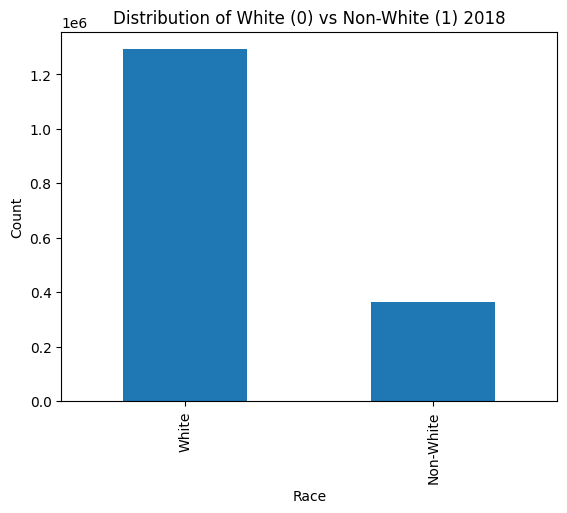

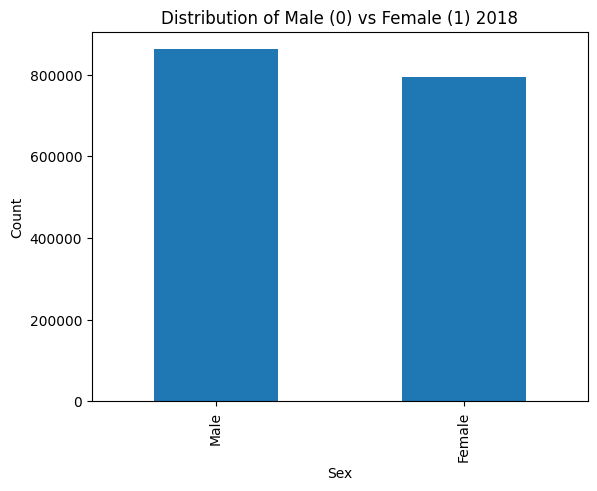

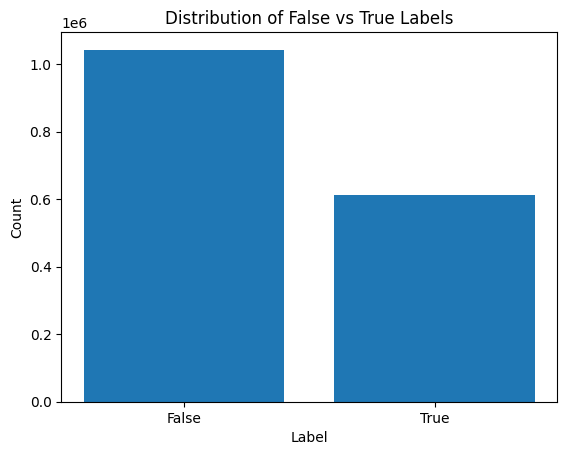

In [6]:
import matplotlib.pyplot as plt

race_distribution = features['RAC1P'].value_counts()
sex_distribution = features['SEX'].value_counts()
# Print the distribution
print("Distribution of White vs Non-White:")
print(race_distribution)

# Plot the distribution
race_distribution.plot(kind='bar')
plt.xlabel('Race')
plt.ylabel('Count')
plt.title('Distribution of White (0) vs Non-White (1) 2018')
plt.xticks(ticks=[0, 1], labels=['White', 'Non-White'])
plt.show()

# Plot the distribution
sex_distribution.plot(kind='bar')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.title('Distribution of Male (0) vs Female (1) 2018')
plt.xticks(ticks=[0, 1], labels=['Male', 'Female'])
plt.show()

true_count = np.sum(labels.values)
false_count = len(labels) - true_count

# Create a bar plot
plt.bar(['False', 'True'], [false_count, true_count])

# Add labels and title
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of False vs True Labels')

# Show plot
plt.show()

In [10]:
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def calculate_fairness_metrics(predictions, labels, sensitive_feature):
    # Statistical Parity
    parity = predictions[sensitive_feature == 0].mean() - predictions[sensitive_feature == 1].mean()

    # True Positive Rate (TPR)
    tpr_0 = (predictions[sensitive_feature == 0] & labels[sensitive_feature == 0]).mean() / labels[
        sensitive_feature == 0].mean()
    tpr_1 = (predictions[sensitive_feature == 1] & labels[sensitive_feature == 1]).mean() / labels[
        sensitive_feature == 1].mean()

    # False Positive Rate (FPR)
    fpr_0 = (predictions[sensitive_feature == 0] & ~labels[sensitive_feature == 0]).mean() / (
        ~labels[sensitive_feature == 0]).mean()
    fpr_1 = (predictions[sensitive_feature == 1] & ~labels[sensitive_feature == 1]).mean() / (
        ~labels[sensitive_feature == 1]).mean()

    return parity, tpr_0, tpr_1, fpr_0, fpr_1


def evaluate_model(features: pd.DataFrame, labels: pd.DataFrame, race=True, sex=True):
    prefix = ''
    if race:
        features = features.copy()
    else:
        features = features.drop(columns=['RAC1P'])
        prefix = 'norace_'
    if sex:
        features = features.copy()
    else:
        features = features.drop(columns=['SEX'])
        prefix = 'nosex_' if race else 'neither_'

    labels = labels.values.astype(bool).ravel()  # Ensuring it's a 1D array

    # Split the data into training and testing sets
    train_features, test_features, train_labels, test_labels = train_test_split(
        features, labels, test_size=0.2, random_state=1)

    # Create and train the logistic regression model
    model = LogisticRegression(max_iter=10000)
    model.fit(train_features, train_labels)

    # Evaluate the model on the test data
    test_predictions = model.predict(test_features)
    accuracy = accuracy_score(test_labels, test_predictions)
    precision = precision_score(test_labels, test_predictions)
    recall = recall_score(test_labels, test_predictions)
    f1 = f1_score(test_labels, test_predictions)
    results = {
        prefix + 'accuracy': accuracy,
        prefix + 'precision': precision,
        prefix + 'recall': recall,
        prefix + 'f1_score': f1,
        prefix + 'true_dp': labels.mean(),
    }

    if race:
        race_parity, race_tpr_0, race_tpr_1, race_fpr_0, race_fpr_1 = calculate_fairness_metrics(test_predictions,
                                                                                                 test_labels,
                                                                                                 test_features['RAC1P'])
        results |= {
            'race_dp': features['RAC1P'].mean(),
            prefix + 'race_parity': race_parity,
            prefix + 'race_tpr_0': race_tpr_0,
            prefix + 'race_tpr_1': race_tpr_1,
            prefix + 'race_tpr_diff': race_tpr_0 - race_tpr_1,
            prefix + 'race_fpr_0': race_fpr_0,
            prefix + 'race_fpr_1': race_fpr_1,
            prefix + 'race_fpr_diff': race_fpr_0 - race_fpr_1,
        }

    if sex:
        sex_parity, sex_tpr_0, sex_tpr_1, sex_fpr_0, sex_fpr_1 = calculate_fairness_metrics(test_predictions,
                                                                                            test_labels,
                                                                                            test_features['SEX'])
        results |= {
            'sex_dp': features['SEX'].mean(),
            prefix + 'sex_parity': sex_parity,
            prefix + 'sex_tpr_0': sex_tpr_0,
            prefix + 'sex_tpr_1': sex_tpr_1,
            prefix + 'sex_tpr_diff': sex_tpr_0 - sex_tpr_1,
            prefix + 'sex_fpr_0': sex_fpr_0,
            prefix + 'sex_fpr_1': sex_fpr_1,
            prefix + 'sex_fpr_diff': sex_fpr_0 - sex_fpr_1,
        }

    return results


def evaluate_predictions(year, state):
    if state == 'XX':
        features, labels = get_all_income_data_by_year(year)
    else:
        features, labels = acs_to_income_df(load_acs(year, state))
    features['RAC1P'] = features['RAC1P'].apply(map_race)
    features['SEX'] = features['SEX'].apply(map_sex)

    results = {
        'year': year,
        'state': state,
    }
    for race, sex in itertools.product([True, False], repeat=2):
        results |= evaluate_model(features, labels, race, sex)

    return results


def prediction_iterator(combs, multi=True):
    if not combs:
        return
    if multi:
        with ThreadPoolExecutor() as pool:
            futures = []
            for year, state in combs:
                future = pool.submit(evaluate_predictions, year, state)
                futures.append(future)
            for future in tqdm(as_completed(futures), total=len(combs)):
                yield future.result()
    else:
        for year, state in tqdm(combs):
            yield evaluate_predictions(year, state)


results_csv = Path('acs_results.csv.gz')


def generate_csv():
    *years, = range(2014, 2023)  # From 2014 to 2018
    combs = {(year, state) for year in years for state in [*_STATE_CODES.keys(), 'XX']}
    results_df = pd.DataFrame()
    results: dict[tuple[int, str], dict] = {}
    if results_csv.exists():
        existing_results_df = pd.read_csv(results_csv, sep=';', compression='gzip')
        existing_combs = set(zip(map(int, results_df['year'].values), results_df['state'].values))
        combs -= existing_combs
        for _, row in existing_results_df.iterrows():
            results[(row['year'], row['state'])] = row.to_dict()
    if combs:
        results_tmp_csv = results_csv.with_suffix('.tmp' + results_csv.suffix)
        for result in prediction_iterator(combs, True):
            results[(result['year'], result['state'])] = result
            results_df = pd.DataFrame([*results.values()])
            if results_csv.exists():
                results_csv.replace(results_tmp_csv)
            results_df.to_csv(results_csv, index=False, sep=';', compression='gzip')

        if results_tmp_csv.exists():
            results_tmp_csv.unlink()

    results_df = pd.DataFrame(sorted(results.values(), key=lambda x: (x['year'], x['state'])))
    results_df.to_csv(results_csv, index=False, sep=';', compression='gzip')
    return results_df


results_df = generate_csv()
# Display the results
print(results_df)


 41%|████      | 187/459 [47:22<1:53:15, 24.98s/it]C:\Users\Ettore\AppData\Local\Temp\ipykernel_7788\3237146021.py:105: DtypeWarning: Columns (126) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)
C:\Users\Ettore\AppData\Local\Temp\ipykernel_7788\3237146021.py:105: DtypeWarning: Columns (96,127) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)
 56%|█████▌    | 257/459 [1:17:13<1:01:24, 18.24s/it]C:\Users\Ettore\AppData\Local\Temp\ipykernel_7788\3237146021.py:105: DtypeWarning: Columns (95,104,126) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)
 88%|████████▊ | 403/459 [2:18:52<17:26, 18.68s/it]  C:\Users\Ettore\AppData\Local\Temp\ipykernel_7788\3237146021.py:105: DtypeWarning: Columns (127) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)
 93%|█████████▎| 425/459 [2:28:40

     year state  accuracy  precision    recall  f1_score   true_dp   race_dp  \
0    2014    AK  0.775034   0.683761  0.640000  0.661157  0.365633  0.410376   
1    2014    AL  0.801549   0.650888  0.488455  0.558092  0.262988  0.252643   
2    2014    AR  0.825403   0.666667  0.401372  0.501071  0.220923  0.169140   
3    2014    AZ  0.781046   0.658520  0.525641  0.584625  0.296980  0.204981   
4    2014    CA  0.798826   0.739596  0.667638  0.701777  0.354608  0.362790   
..    ...   ...       ...        ...       ...       ...       ...       ...   
454  2022    WA  0.770096   0.766470  0.803764  0.784674  0.518386  0.318333   
455  2022    WI  0.755263   0.725838  0.684459  0.704541  0.420999  0.115893   
456  2022    WV  0.754551   0.681363  0.594406  0.634921  0.360874  0.092667   
457  2022    WY  0.759434   0.729469  0.608871  0.663736  0.394778  0.157597   
458  2022    XX  0.763252   0.735492  0.725230  0.730325  0.442010  0.327433   

     race_parity  race_tpr_0  ...  nora

In [12]:
results_df.to_csv(results_csv.with_name(results_csv.stem), index=False, sep=';')

In [11]:
import matplotlib.pyplot as plt


def plot_fairness_metrics_for_state(state, save_folder=None):
    save_folder = Path('.' if save_folder is None else save_folder)
    save_folder.mkdir(parents=True, exist_ok=True)

    data = results_df[results_df['state'] == state]
    figsize = (10, 6)

    def _plot_metrix(mode=None, desc=None):
        prefix = '' if mode is None else (mode + '_')
        suffix = '' if mode is None else ('_' + mode)
        state_suffix = f' for {state}' if state != 'XX' else ''
        desc_suffix = '' if desc is None else f" ({desc})"

        if mode is None:
            # Plot 1: Demographic Percentages
            fig1, ax1 = plt.subplots(figsize=figsize)
            ax1.plot(data['year'], data['true_dp'], marker='o', label='$50k+ Percentage')
            ax1.plot(data['year'], data['sex_dp'], marker='o', label='Female Percentage')
            ax1.plot(data['year'], data['race_dp'], marker='o', label='Non-White Percentage')
            ax1.set_xlabel('Year')
            ax1.set_ylabel('Percentage')
            ax1.set_title('Demographic Percentages Over Time' + state_suffix)
            ax1.legend()
            ax1.grid(axis='y')
            fig1.savefig(save_folder / f'demographic_percentages_{state}.png', transparent=True)
            plt.close(fig1)

        # Plot 2: Performance Metrics
        fig2, ax2 = plt.subplots(figsize=figsize)
        ax2.plot(data['year'], data[prefix + 'accuracy'], marker='o', label='Accuracy')
        ax2.plot(data['year'], data[prefix + 'precision'], marker='o', label='Precision')
        ax2.plot(data['year'], data[prefix + 'recall'], marker='o', label='Recall')
        ax2.plot(data['year'], data[prefix + 'f1_score'], marker='o', label='F1 Score')
        ax2.set_xlabel('Year')
        ax2.set_ylabel('Score')
        ax2.set_title('Performance Metrics Over Time' + state_suffix + desc_suffix)
        ax2.legend()
        ax2.grid(axis='y')
        fig2.savefig(save_folder / f'performance_metrics_{state}{suffix}.png', transparent=True)
        plt.close(fig2)

        if (prefix + 'race_parity') in data.columns:
            # Plot 3: Race Fairness Metrics
            fig3, ax3 = plt.subplots(figsize=figsize)
            ax3.plot(data['year'], data[prefix + 'race_tpr_diff'], marker='o', label='TPR White - TPR Non-White')
            ax3.plot(data['year'], data[prefix + 'race_fpr_diff'], marker='o', label='FPR White - FPR Non-White')
            ax3.plot(data['year'], data[prefix + 'race_parity'], marker='o', label='Parity')
            ax3.set_xlabel('Year')
            ax3.set_ylabel('Difference')
            ax3.set_title('Race Fairness Metrics Differences Over Time' + state_suffix + desc_suffix)
            ax3.legend()
            ax3.grid(axis='y')
            fig3.savefig(save_folder / f'race_fairness_metrics_{state}{suffix}.png', transparent=True)
            plt.close(fig3)

        if (prefix + 'sex_parity') in data.columns:
            # Plot 4: Sex Fairness Metrics
            fig4, ax4 = plt.subplots(figsize=figsize)
            ax4.plot(data['year'], data[prefix + 'sex_tpr_diff'], marker='o', label='TPR Male - TPR Female')
            ax4.plot(data['year'], data[prefix + 'sex_fpr_diff'], marker='o', label='FPR Male - FPR Female')
            ax4.plot(data['year'], data[prefix + 'sex_parity'], marker='o', label='Parity')
            ax4.set_xlabel('Year')
            ax4.set_ylabel('Difference')
            ax4.set_title('Sex Fairness Metrics Differences Over Time' + state_suffix + desc_suffix)
            ax4.legend()
            ax4.grid(axis='y')
            fig4.savefig(save_folder / f'sex_fairness_metrics_{state}{suffix}.png', transparent=True)
            plt.close(fig4)

    for mode, desc in (None, None), ('norace', 'No Race'), ('nosex', 'No Sex'), ('neither', 'No Race and Sex'):
        _plot_metrix(mode, desc)


# No need to explicitly call plt.show() now
plots_folder = Path('plots')
for state in _STATE_CODES.keys():
    plot_fairness_metrics_for_state(state, plots_folder / state)
plot_fairness_metrics_for_state('XX', plots_folder)


In [ ]:

def plot_income_trends_by_group():
    """
    Plots the percentage of individuals earning over $50k over time, 
    separating by race (White vs. Non-White) and gender (Male vs. Female).
    """

    # Data structures to store percentages for each group
    pct_non_white_over_50k = []
    pct_white_over_50k = []
    pct_male_over_50k = []
    pct_female_over_50k = []

    for year in years:
        # Fetch data for the current year
        features, labels = get_all_income_data_by_year(year)

        features['RAC1P'] = features['RAC1P'].apply(map_race)
        features['SEX'] = features['SEX'].apply(map_sex)

        # Calculate percentages for each group
        total_non_white = (features['RAC1P'] == 1).sum()
        total_white = (features['RAC1P'] == 0).sum()
        total_male = (features['SEX'] == 0).sum()
        total_female = (features['SEX'] == 1).sum()

        non_white_over_50k = ((features['RAC1P'] == 1) & labels).sum() / total_non_white
        white_over_50k = ((features['RAC1P'] == 0) & labels).sum() / total_white
        male_over_50k = ((features['SEX'] == 0) & labels).sum() / total_male
        female_over_50k = ((features['SEX'] == 1) & labels).sum() / total_female

        # Store the percentages
        pct_non_white_over_50k.append(non_white_over_50k)
        pct_white_over_50k.append(white_over_50k)
        pct_male_over_50k.append(male_over_50k)
        pct_female_over_50k.append(female_over_50k)

    # Create a dictionary to store the data for the DataFrame
    group_data = {
        'Year': years,
        'Pct_White_Over_50k': pct_white_over_50k,
        'Pct_Non_White_Over_50k': pct_non_white_over_50k,
        'Pct_Male_Over_50k': pct_male_over_50k,
        'Pct_Female_Over_50k': pct_female_over_50k
    }

    # Create the Pandas DataFrame
    df = pd.DataFrame(group_data)

    # Export to CSV (you can change the filename as needed)
    df.to_csv('income_trends_by_group.csv', index=False)

    # Create the plots
    plt.figure(figsize=(12, 6))

    # Plot for race
    plt.subplot(1, 2, 1)
    plt.plot(years, pct_white_over_50k, label='White', marker='o')
    plt.plot(years, pct_non_white_over_50k, label='Non-White', marker='o')
    plt.title('Percentage Earning Over $50k by Race')
    plt.xlabel('Year')
    plt.ylabel('Percentage')
    plt.legend()

    # Plot for gender
    plt.subplot(1, 2, 2)
    plt.plot(years, pct_male_over_50k, label='Male', marker='o')
    plt.plot(years, pct_female_over_50k, label='Female', marker='o')
    plt.title('Percentage Earning Over $50k by Gender')
    plt.xlabel('Year')
    plt.ylabel('Percentage')
    plt.legend()

    plt.tight_layout()
    plt.savefig('percentage_trends_by_group.png', transparent=True)
    plt.show()


# Assuming you have the `years` variable defined somewhere, call the function
plot_income_trends_by_group()


In [ ]:
results_df['sex_tpr_diff'] = results_df['sex_tpr_0'] - results_df['sex_tpr_1']
results_df['sex_fpr_diff'] = results_df['sex_fpr_0'] - results_df['sex_fpr_1']
results_df['race_tpr_diff'] = results_df['race_tpr_0'] - results_df['race_tpr_1']
results_df['race_fpr_diff'] = results_df['race_fpr_0'] - results_df['race_fpr_1']
results_df.to_csv(results_csv, index=False, compression='gzip')

In [ ]:
# Evaluate the difference of the fairness metrics from 2014 to 2022 for each state

metrics = ['accuracy', 'precision', 'recall', 'f1_score']
differences = []
for state in ['XX', *_STATE_CODES.keys()]:
    data = results_df[results_df['state'] == state]
    diff = {'state': state, **{
        m: data[m].values[-1] - data[m].values[0] for m in metrics
    }}
    differences.append(diff)
diff_df = pd.DataFrame(differences)

fig, axs = plt.subplots(len(metrics), figsize=(15, 6 * len(metrics)))
for i, metric in enumerate(metrics):
    ax = axs[i]
    data = diff_df[['state', metric]].sort_values(by=metric, ascending=False)
    us = data[data['state'] == 'XX'][metric].values[0]
    ax.axhline(us, color='r', linestyle='--', label='US')
    ax.bar(data['state'], data[metric])
    ax.set_xlabel('State')
    ax.set_ylabel('Difference')
    ax.set_title(f'{metric.capitalize()} Difference from 2014 to 2022')
plt.show()
